In [1]:
using Plots;
using Trapz;
using Distributions
using Interpolations;
using ForwardDiff; 
using DataFrames;
using CSV;
using ZChop;
using ImageFiltering;
using StatsBase;
using Random;



In [2]:
#get previous alg output. 
df_new = CSV.read("../OVERDAMPED/results_kl_land_new1.csv",DataFrame,header=true);

In [9]:
const global tau =  Int(1)
#const global beta = Float32(1)
const global L = Int(1)
const global m = Int(1)

const global T_initial = Int(0)
const global T_final = 0.2

const global epsilon = 1  #Float32(sqrt(tau^2/(m*beta*(L^2))))
const global beta = 1/epsilon 

###############

#location of peaks
const global peak_location = 1

###############

#space discretisation
global x_samples = 2500 #number of sample points per batch
global p_samples = 2500
global interval_start = -3
global interval_end = 3
global p_axis = collect(transpose(Float32.(Array(range(interval_start,interval_end,p_samples)))));


#intial and final distributions
###########
global function p_initial(y)

    return exp.(-((y.-peak_location).^4)/4)
end;


global function p_final(y)

    return exp.(-(((y.^2).-(peak_location^2)).^2)/4);
end;


global function normalisation(y)
    
    return replace(y ./ abs(trapz(vec(p_axis),vec(abs.(y)))),NaN=>0)
end


#initialise value function
global function v_final(y)
    
    return  -y .^2
end
###############

#u initial drift
global function u_initial(q)     
    return -log.(p_initial(q))
     
end;


#calculate normalisation for distributions
int_range = Array(range(-8,8,8000))
norm_range = Array(range(-8,8,8000))

global normfinal = abs.(trapz(norm_range,p_final(norm_range)));
global norminitial = abs.(trapz(norm_range,p_initial(norm_range)));
global weights_pfinal = vec(p_final(int_range)) #/normfinal

global T = T_final;

global filter_delta = 40;

In [10]:
##define the time mesh##
time_interval = vec(unique(df_new.t))
global time_interval = round.(time_interval;digits = 4)

global time_grid = Int(length(time_interval));

global time_steps_vec = [round.(time_interval[Int(k+1)]-time_interval[Int(k)];digits =3) for k in 1:length(time_interval)-1];
global plot_times = time_interval[begin:4:end]; #these times are used in the plots

In [11]:
##filtering functions
function filtering(input_array,filter_delta)
    
    #= this function implements a simple box filter of size filter_delta and padds missing reults
    
    inputs: 
    input_array - array to be smooths
    filter_delta - size of filter, number of nearest neighbours to consider
    
    output:
    filtered array with borders filled with constant value. 
    =#
    
    return imfilter(vec(input_array),reflect((1/filter_delta).*centered(ones(filter_delta))),Pad(:replicate))
    
end;

In [12]:
##Testing use only. 
#these are the drift and value computed by caluya halder as interpolation functions

#caluya-halder value function
function v_opt(y)
    
    filtered_df = filter(row -> row.t == T, df_new)
    
    itp = linear_interpolation(vec(filtered_df.x),vec(filtered_df.sigma),extrapolation_bc = Line())
    #itp = linear_interpolation(vec(filtered_df.x),vec(filtered_df.vtx),extrapolation_bc = Line())
    
    return -(beta/2)*itp.(y) #log(phi)
end;


du_vec = []

for t in 1:length(time_interval)
    filtered_df = filter(row -> row.t == round(time_interval[t];digits=3), df_new)
    itp = linear_interpolation(vec(filtered_df.x),vec(filtered_df.sigma),extrapolation_bc = Line())
    dsigtemp = ForwardDiff.derivative.(Ref(itp), vec(filtered_df.x)) #filtering(ForwardDiff.derivative.(Ref(itp), vec(filtered_df.x)),40)
    du_vec = append!(du_vec,dsigtemp)

end


In [14]:
df_new[!,:du_vec] = du_vec;

#add gradient column to dataframe
function du_opt(time,y)
    
    filtered_df = filter(row -> row.t == round(time;digits=4), df_new)
    
    itp = linear_interpolation(vec(filtered_df.x),vec(filtered_df.du_vec),extrapolation_bc = Line())
    
    return itp.(y)
end;

#
function value_opt(time,y)
    
    filtered_df = filter(row -> row.t == round(time;digits=4), df_new)
    
    itp = linear_interpolation(vec(filtered_df.x),vec(filtered_df.sigma),extrapolation_bc = Line())
    
    return -(beta/2)*itp.(y) #log(phi)
end;

#second derivative approximation
function ddu_opt(time,y)
        
    itp = linear_interpolation(vec(p_axis),vec(filtering(du_opt(time,p_axis),40)),extrapolation_bc = Line())
    
    return ForwardDiff.derivative.(Ref(itp),y)
end;


#second derivative approximation
function dddu_opt(time,y)
        
    itp = linear_interpolation(vec(p_axis),vec(filtering(ddu_opt(time,p_axis),40)),extrapolation_bc = Line())
    
    return ForwardDiff.derivative.(Ref(itp),y)
end;


In [15]:

vtx = zeros(time_grid,x_samples) #values_t(x) (function of q) 
ptx = zeros(time_grid,x_samples); #p_t(x) (func of  q) 


In [16]:
#Random.seed!(74)
mc_samples_ptx = 10000

###GET POINT CLOUDS
x_init::Array{Float32,2} = p_axis #rand(initial_sampler,(1,x_samples))

########DISTRIBUTION W. GIRSANOV#########

for t in 1:time_grid

    #setup
    y_t = copy(repeat(x_init, outer = [1,1,mc_samples_ptx])) #initialise x_t
    girsanov_term::Array{Float32,3} = zeros((1,x_samples,mc_samples_ptx))  #cumulative term for girsanov weights

    #####COMPUTE DISTRIBUTION at t = T
    for i in 1:t-1

        #sample a brownian motion
        currtime::Float64 = time_interval[t-i+1]
        currdt::Float64 = abs(time_interval[t-i] - currtime) #time_step

        #sample brownian noise: W_{i-1} - W_i 
        innovation::Array{Float32,3} = rand(Normal(0,1),(1,x_samples,mc_samples_ptx))

        #one step of reverse sde
        y_t .-= sqrt(2*currdt/beta).*innovation  #compute x_{t_{i-1}}
        
        currdrift = du_opt(currtime,y_t)  #get current drift

        girsanov_term .+= sqrt(beta*currdt/2).*innovation.*currdrift .+ currdt*(beta/4).*(currdrift.^2) #add to girsanov weight

    end

    ######

    p_vals::Array{Float32,2} = mean(exp.(-beta*u_initial(y_t).- girsanov_term),dims=3)[:,:,1]
    ptx[t,:] = p_vals./ norminitial

end


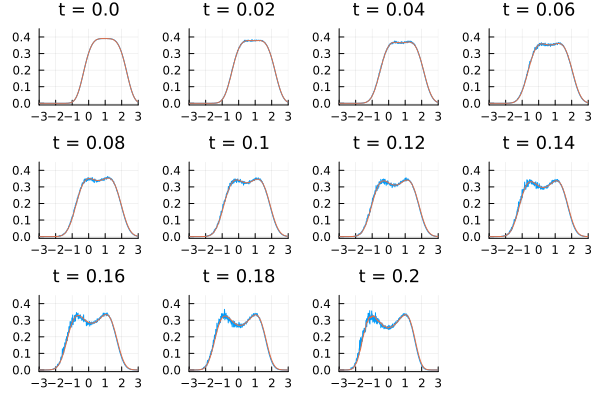

In [11]:
##Distribution
p2 = plot(layout = 10+1)

#evolve
for t in 1:11

    curr_time = plot_times[t]
    
    filtered_df = filter(row -> row.t == curr_time, df_new)

    plot!(p2,vec(p_axis),normalisation(vec(ptx[(t-1)*4+1,:])),subplot=t,label = "drift output",title ="t = $curr_time",titlefontsize = 12)
    plot!(p2,vec(filtered_df.x),filtered_df.rho,subplot=t,label = "drift output")

end


plot!(ylim=(-0.01,0.45))

plot!(p2,legend = false)
plot!(xlim=(interval_start,interval_end))
plot(p2)
#savefig("od_gauss_dv.png")

In [17]:
####DRIFT########
dvtx = zeros(time_grid,x_samples); #p_t(x) (func of  q) 
dvtx_nogirs = zeros(time_grid,x_samples); #dv_t(x) (func of  q) 
vtx = zeros(time_grid,x_samples); #dv_t(x) (func of  q) 
vtx_nogirs = zeros(time_grid,x_samples); #dv_t(x) (func of  q) 

mc_samples_dvtx = mc_samples_ptx
x_0::Array{Float64,3} = copy(repeat(p_axis, outer = [1,1,mc_samples_dvtx]))

#compute evolutions of dvtx
for t::Int in 1:time_grid-1

    #get current time
    #this is the time at which we compute the approximation
    curr_time::Float64 = time_interval[t]

    #for dvtx
    x_t::Array{Float64,3} = copy(repeat(p_axis, outer = [1,1,mc_samples_dvtx]))
    y_t::Array{Float64,3} = copy(repeat(p_axis, outer = [1,1,mc_samples_dvtx]))

    girsanov_value::Array{Float64,3} = zeros((1,x_samples,mc_samples_dvtx))
    int_exp::Array{Float64,3} = zeros((1,x_samples,mc_samples_dvtx))  #store the integral
    int_exp_nogirs::Array{Float64,3} = zeros((1,x_samples,mc_samples_dvtx))  #store the integral
    int1::Array{Float64,3} = zeros((1,x_samples,mc_samples_dvtx))  #store the integral
    int2::Array{Float64,3} = zeros((1,x_samples,mc_samples_dvtx))  #store the integral
    int_currddu::Array{Float64,3} = zeros((1,x_samples,mc_samples_dvtx))  #store the integral
    int_currddu_nogirs::Array{Float64,3} = zeros((1,x_samples,mc_samples_dvtx))  #store the integral

    iota::Array{Float64,3} = zeros((1,x_samples,mc_samples_dvtx))  #store the integral
    iota_nogirs::Array{Float64,3} = zeros((1,x_samples,mc_samples_dvtx))  #store the integral
    
    for i in t:time_grid-1

        #get current times from discretisation
        currtime::Float64 = time_interval[i]
        currdt::Float64 = abs(time_interval[i+1] - currtime)
        
        #compute current drift
        currdu::Array{Float64,3} = du_opt(currtime,x_t)
        currdu_nogirs::Array{Float64,3} = du_opt(currtime,y_t)
        #currddu = ddu_opt(currtime,x_t)
        currddu_nogirs = ddu_opt(currtime,y_t)
          
        
        #get update step 
        innovation::Array{Float64,3} = rand(Normal(0,1),(1,x_samples,mc_samples_dvtx))

        #evaluate integrals
        girsanov_value .+= sqrt(beta*currdt/2).*innovation.*(currdu) .+ currdt*(beta/4).*((currdu).^2)
        
        if i == t
                  
            #int_currddu .+= sqrt(currdt).*innovation.*exp.(-int_exp)
            int_currddu_nogirs .+= sqrt(currdt)*innovation.*exp.(-int_exp_nogirs)

            #int1 .+= currdt*int_currddu.*(currdu.^2)
            int2 .+= currdt*int_currddu_nogirs.*(currdu_nogirs.^2) 
        
            else #i>t
            #int_exp .+= currdt*currddu
            int_exp_nogirs .+= currdt*currddu_nogirs
            
            #int_currddu .+= sqrt(currdt).*innovation.*exp.(-int_exp)
            int_currddu_nogirs .+= sqrt(currdt)*exp.(-int_exp_nogirs).*innovation

            #int1 .+= currdt*int_currddu.*(currdu.^2) ./ (currtime - curr_time) 
            int2 .+= currdt*int_currddu_nogirs.*(currdu_nogirs.^2) ./ (currtime - curr_time) 
        
            
        end   
        
        iota .+= (beta*currdt/4)*(currdu.^2)
        iota_nogirs .+= (beta*currdt/4)*(currdu_nogirs.^2)

        #go forward one step
        x_t .+= sqrt(2*currdt/beta) .*innovation
        y_t = y_t .- (currdu_nogirs.*currdt) .+ sqrt(2*currdt/beta) .*innovation

    end

    #compute dv 
    vout::Array{Float32,3} = -v_opt(x_t)
    vout_nogirs::Array{Float32,3} = -v_opt(y_t)

    
    #dvtx[t,:] = sqrt(beta/2)*mean((exp.(- girsanov_value)).*
    #                    (vout.*int_currddu/(T-curr_time) + (beta/4)*int1),dims=3)[:,:,1]
    dvtx_nogirs[t,:] = sqrt(beta/2)*mean((vout_nogirs.*int_currddu_nogirs/(T-curr_time) + (beta/4)*int2),dims=3)[:,:,1]

    
    vtx[t,:] = mean((vout .+ iota).*exp.(-girsanov_value),dims=3)[:,:,1]
    vtx_nogirs[t,:] = mean((vout_nogirs .+ iota_nogirs),dims=3)[:,:,1]

    
end    



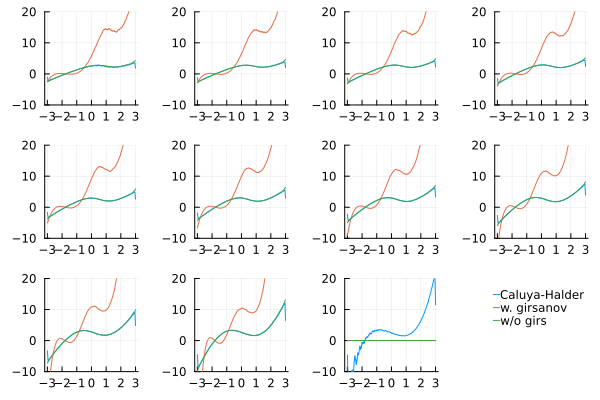

In [18]:

p2 = plot(layout = 12)

#evolve

for t in 1:11

    curr_time = plot_times[t]
    
    value_data = -filtering(vec(value_opt(curr_time,p_axis)),40)
    itp_temp = linear_interpolation(vec(p_axis),value_data,extrapolation_bc=Line())
    
    plot!(vec(p_axis),ForwardDiff.derivative.(Ref(itp_temp),vec(p_axis)),subplot=t)
    
    plot!(p2,vec(p_axis),-filtering(vec(dvtx[(t-1)*4+1,:]),40),subplot=t,label = "drift output")
    plot!(p2,vec(p_axis),filtering(vec(dvtx_nogirs[(t-1)*4+1,:]),40),subplot=t,label = "drift output")
    
end

#plot!(p2,xlim =(-2,2))

plot!(p2,ylim =(-10,20))
plot!(p2,legend = false)
plot!(p2,[],[],framestyle = :none,legend = true,labels = "Caluya-Halder", subplot = 12)
plot!(p2,[],[],framestyle = :none,legend = true,labels = "w. girsanov", subplot = 12,fg_legend = :false)
plot!(p2,[],[],framestyle = :none,legend = true,labels = "w/o girs", subplot = 12,fg_legend = :false)

plot(p2)



#savefig("od_dw_drifts_approx_val.png")*



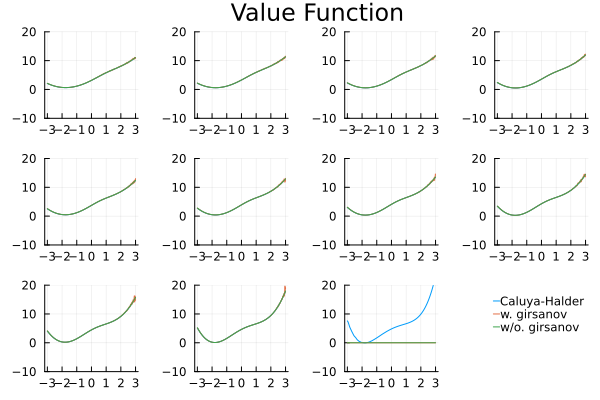

In [20]:

p2 = plot(layout = 12)

#evolve

for t in 1:11

    curr_time = plot_times[t]
    
    filtered_df = filter(row -> row.t == curr_time, df_new)

    plot!(vec(p_axis),-filtering(vec(value_opt(curr_time,p_axis)),40),subplot=t)

    plot!(p2,vec(p_axis),filtering(vec(vtx[(t-1)*4+1,:]),10),subplot=t,label = "drift output")
    plot!(p2,vec(p_axis),filtering(vec(vtx_nogirs[(t-1)*4+1,:]),10),subplot=t,label = "drift output")
    
end

#plot!(p2,xlim =(-2,2))

plot!(p2,ylim =(-10,20))
plot!(p2,legend = false)
plot!(p2,[],[],framestyle = :none,legend = true,labels = "Caluya-Halder", subplot = 12)
plot!(p2,[],[],framestyle = :none,legend = true,labels = "w. girsanov", subplot = 12,fg_legend = :false)
plot!(p2,[],[],framestyle = :none,legend = true,labels = "w/o. girsanov", subplot = 12,fg_legend = :false)

plot!(p2,suptitle="Value Function")
plot(p2)


#savefig("od_dw_drifts_approx_val.png")

In [19]:
#filter_delta=40
####save a csv file  
file_name = "entropy_plots_v5.csv"

# Define the header as an array of strings
row = ["t" "x" "ptx" "dvtx"]
header = DataFrame(row,["t", "x", "ptx", "dvtx"])

# Write the header to a new CSV file
CSV.write(file_name, header;header =false)

for t in 1:time_grid
    
    ptx_temp = filtering(vec(normalisation(ptx[t,:])),filter_delta)
    dvtx_temp = filtering(vec(dvtx_nogirs[t,:]),filter_delta)

      
    df = DataFrame([vec(time_interval[t].*ones(x_samples)),
                    vec(round.(p_axis,digits=4)),
                    vec(ptx_temp),
                    vec(dvtx_temp)],
                    ["t", "x", "ptx", "dvtx"])

    #drop nans 
    #filter!(:sigma => x -> !any(f -> f(x), (isinf, ismissing, isnothing, isnan)), df)

    CSV.write(file_name, df,append =true)
    
end

